🔍 Scanning dataset...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
✅ A1_test1.jpg — True: A, Predicted: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
✅ A2_test.jpg — True: A, Predicted: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
✅ A_test.jpg — True: A, Predicted: A
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
✅ B1_test.jpg — True: B, Predicted: B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
✅ B2_test.jpg — True: B, Predicted: B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
✅ B_test.jpg — True: B, Predicted: B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
✅ C1_test.jpg — True: C, Predicted: C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
✅ C2_test.jpg — True: C, Predicted: C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
✅ C_test.jpg — True: C, Predicted: C
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
✅ D1_test.jpg — True: D, Predicted: I
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
✅ D2_test.jpg — True: D, Predicted: I
❌ No hand detected in: del1_test.jpg
❌ No hand detected in: del2_test.jpg
❌ No hand detected in: del_test.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/s

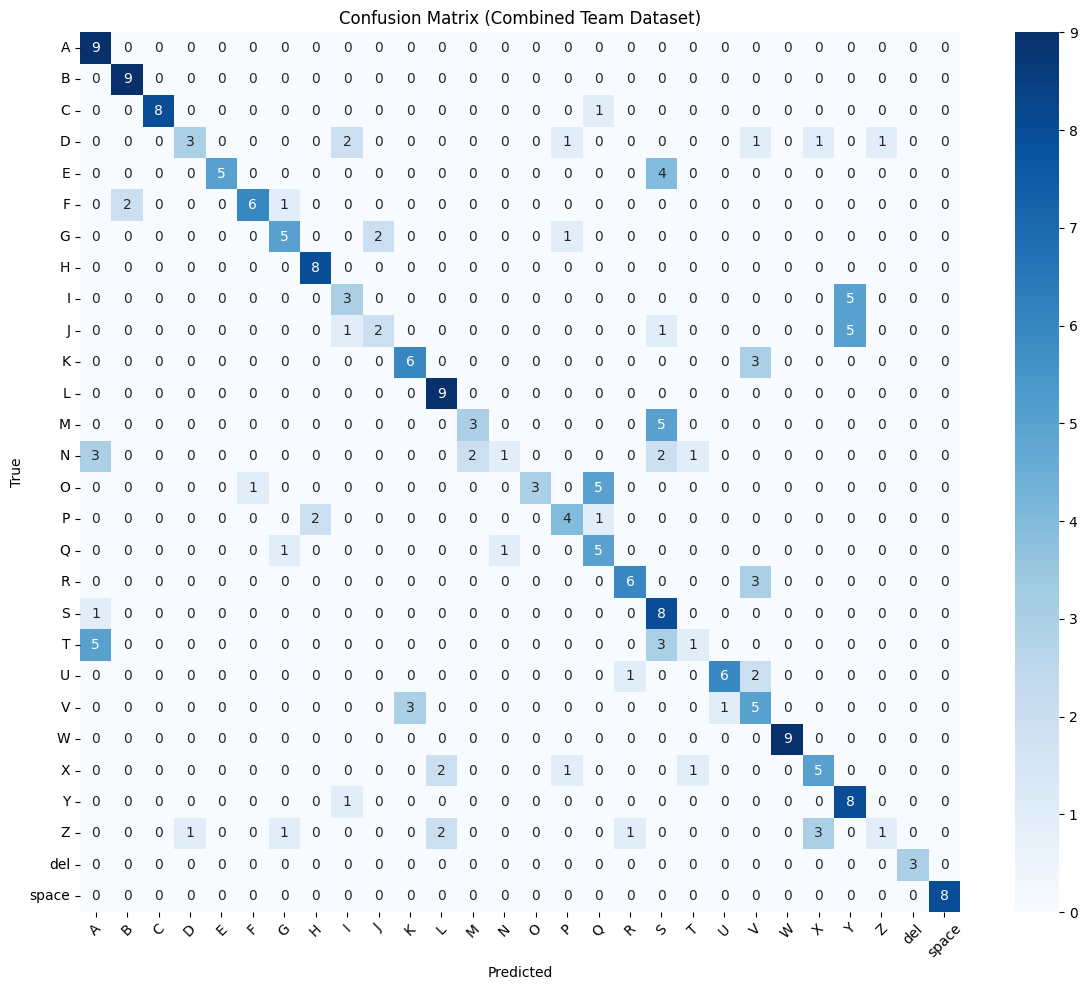


📋 Classification Report:
              precision    recall  f1-score   support

           A       0.50      1.00      0.67         9
           B       0.82      1.00      0.90         9
           C       1.00      0.89      0.94         9
           D       0.75      0.33      0.46         9
           E       1.00      0.56      0.71         9
           F       0.86      0.67      0.75         9
           G       0.62      0.62      0.62         8
           H       0.80      1.00      0.89         8
           I       0.43      0.38      0.40         8
           J       0.50      0.22      0.31         9
           K       0.67      0.67      0.67         9
           L       0.69      1.00      0.82         9
           M       0.60      0.38      0.46         8
           N       0.50      0.11      0.18         9
           O       1.00      0.33      0.50         9
           P       0.57      0.57      0.57         7
           Q       0.42      0.71      0.53         7
 

In [2]:
import os
import cv2
import numpy as np
import pickle
import re
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import mediapipe as mp

# --- Config ---
DATA_DIR = 'ASL_Alphabet_Dataset\\TeamDataset'  # change this
VALID_LABELS = set("ABCDEFGHIJKLMNOPQRSTUVWXYZ")  # adapt if lowercase or includes 'space', 'del'
MIN_CONF = 0.5 # mediapipe detection threshold

# Load model & label encoder
model = load_model('asl_cnn_2D_model.h5')
with open('label_encoder.pickle', 'rb') as f:
    label_encoder = pickle.load(f)
CLASS_NAMES = label_encoder.classes_

# Mediapipe setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=MIN_CONF)

# Storage
true_labels = []
predicted_labels = []

# Helper to extract label from filename
def extract_label_from_filename(fname):
    """
    Extracts raw label (preserving casing) from filenames like:
    - A1_test.jpg → A
    - space2_test.jpg → space
    - del3_test.jpg → del
    - Z_test.jpg → Z
    """
    base = os.path.splitext(fname)[0]     # e.g., 'space2_test'
    label_part = base.split('_')[0]       # e.g., 'space2'
    label = re.sub(r'\d+', '', label_part)  # Remove digits: 'space2' → 'space'
    return label if label else None

# Loop through all folders/files
print("🔍 Scanning dataset...")
for root, _, files in os.walk(DATA_DIR):
    for file in files:
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        true_label = extract_label_from_filename(file)
        if not true_label or true_label not in CLASS_NAMES:
            continue  # skip unknown or unsupported labels

        file_path = os.path.join(root, file)
        image = cv2.imread(file_path)
        if image is None:
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if not results.multi_hand_landmarks:
            print(f"❌ No hand detected in: {file}")
            continue

        # Extract 42 features
        for hand_landmarks in results.multi_hand_landmarks:
            landmark_data = []
            for point in hand_landmarks.landmark:
                landmark_data.append(point.x)
                landmark_data.append(point.y)

            if len(landmark_data) < 42:
                continue

            input_data = np.array(landmark_data[:42]).reshape(1, -1)
            prediction = model.predict(input_data)
            predicted_index = np.argmax(prediction, axis=1)[0]
            predicted_label = CLASS_NAMES[predicted_index]

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)

            print(f"✅ {file} — True: {true_label}, Predicted: {predicted_label}")

# Results
if true_labels:
    acc = accuracy_score(true_labels, predicted_labels)
    print(f"\n✅ Cross-Dataset Accuracy: {acc:.4f}")

    cm = confusion_matrix(true_labels, predicted_labels, labels=CLASS_NAMES)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title("Confusion Matrix (Combined Team Dataset)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\n📋 Classification Report:")
    print(classification_report(true_labels, predicted_labels, labels=CLASS_NAMES))
else:
    print("❌ No valid hand detections made from the cross-check dataset.")
